[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">](https://github.com/jeshraghian/snntorch/)

# snnTorch - 2nd Order Spiking Neuron Models
## Tutorial 4
### By Jason K. Eshraghian (www.ncg.ucsc.edu)
### 偏白话文翻译： manesec

<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_4_advanced_neurons.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub-Mark-Light-120px-plus.png?raw=true' width="28">](https://github.com/jeshraghian/snntorch/) [<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub_Logo_White.png?raw=true' width="80">](https://github.com/jeshraghian/snntorch/)

snnTorch 教程系列基于以下论文。如果您发现这些资源或代码对您有帮助，请考虑引用以下来源：

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". arXiv preprint arXiv:2109.12894, September 2021.](https://arxiv.org/abs/2109.12894) </cite>


# 介绍

在本教程中，您将：
* 了解改进版的 带泄漏整合发放模型 (LIF) 神经元模型： 突触（`Synaptic`） 和 `Alpha`

 单击以下单元格并按 “Shift+Enter”，安装 snnTorch 的最新 PyPi 发行版。

In [1]:
!pip install snntorch

In [2]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
#@title Plotting Settings

def plot_spk_cur_mem_spk(spk_in, syn_rec, mem_rec, spk_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(4, figsize=(8,7), sharex=True,
                        gridspec_kw = {'height_ratios': [0.4, 1, 1, 0.4]})

  # Plot input current
  splt.raster(spk_in, ax[0], s=400, c="black", marker="|")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title("Synaptic Conductance-based Neuron Model With Input Spikes")
  ax[0].set_yticks([])

  # Plot membrane potential
  ax[1].plot(syn_rec.detach().numpy())
  ax[1].set_ylim([0, 0.5])
  ax[1].set_ylabel("Synaptic Current ($I_{syn}$)")
  plt.xlabel("Time step")

  # Plot membrane potential
  ax[2].plot(mem_rec.detach().numpy())
  ax[2].set_ylim([0, 1.5])
  ax[2].set_ylabel("Membrane Potential ($U_{mem}$)")
  ax[2].axhline(y=1, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk_rec, ax[3], s=400, c="black", marker="|")
  plt.ylabel("Output spikes")
  ax[3].set_yticks([])

  plt.show()

def plot_spk_mem_spk(spk_in, mem_rec, spk_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True,
                        gridspec_kw = {'height_ratios': [0.4, 1, 0.4]})

  # Plot input current
  splt.raster(spk_in, ax[0], s=400, c="black", marker="|")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)
  ax[0].set_yticks([])

  # Plot membrane potential
  ax[1].plot(mem_rec.detach())
  ax[1].set_ylim([0, 0.6])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  ax[1].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk_rec, ax[2], s=400, c="black", marker="|")
  ax[2].set_yticks([])
  ax[2].set_ylabel("Output Spikes")

  plt.show()

# 1. 基于突触(Synaptic) 电导的 LIF 神经元模型
之前的教程中探讨的神经元模型，假设输入电压尖峰会导致突触电流的瞬间跃变，然后影响膜电位。实际上，尖峰会经过神经递质从突触前神经元逐渐释放到突触后神经元。基于突触电导的 LIF 模型考虑了输入电流的渐进时间动态。

## 1.1 突触电流建模

如果突触前神经元 (pre-synaptic neruon) 放电，电压尖峰会沿着神经元的轴突传递。然后下图的囊泡(vesicles) 将会释放 神经传递物质(neurotransmitters) 到 突触(synaptic) 间隙。它们激活突触后受体，直接影响流入突触后神经元的有效电流。下图显示了两种类型的兴奋性受体：AMPA 和 NMDA。

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_6_synaptic.png?raw=true' width="600">
</center>

最简单的突触电流模型假设电流在非常快的时间尺度上增加，然后是相对较慢的指数衰减，如上面的 AMPA 图标所示。 这与拉皮克（Lapicque）模型的膜势动力学非常相似。

突触模型有两个指数衰减项：$I_{\rm syn}(t)$ 和 $U_{\rm mem}(t)$。 $I_{\rm syn}(t)$ 的后续项之间的比率（即衰减率）设置为 $\alpha$，$U(t)$ 的后续项之间的比率设置为 $\beta$：

$$ \alpha = e^{-\Delta t/\tau_{\rm syn}}$$

$$ \beta = e^{-\Delta t/\tau_{\rm mem}}$$

其中单个时间步长的持续时间为 $\Delta t = 1$。 $\tau_{\rm syn}$ 对突触电流的时间常数进行建模，其方式与 $\tau_{\rm mem}$ 对膜电位的时间常数进行建模类似。 $\beta$ 的导出方式与之前的教程完全相同，与 $\alpha$ 的方法类似：

$$I_{\rm syn}[t+1]=\underbrace{\alpha I_{\rm syn}[t]}_\text{decay} + \underbrace{WX[t+1]}_\text{input}$$

$$U[t+1] = \underbrace{\beta U[t]}_\text{decay} + \underbrace{I_{\rm syn}[t+1]}_\text{input} - \underbrace{R[t]}_\text{reset}$$

与之前的 LIF 神经元相同的尖峰条件仍然成立：

$$S_{\rm out}[t] = \begin{cases} 1, &\text{if}~U[t] > U_{\rm thr} \\
0, &\text{otherwise}\end{cases}$$


## 1.2 snnTorch 中的突触神经元模型

基于突触电导的神经元模型将突触电流动力学与被动膜结合起来，它必须通过两个输入参数实例化：
* $\alpha$：突触电流的衰减率
* $\beta$：膜电位衰减率（与 Lapicque 相同）

In [4]:
# Temporal dynamics
alpha = 0.9
beta = 0.8
num_steps = 200

# Initialize 2nd-order LIF neuron
lif1 = snn.Synaptic(alpha=alpha, beta=beta)

使用此神经元与之前的 LIF 神经元完全相同，但现在添加了突触电流`syn`作为输入和输出：

**输入**
* `spk_in`：每个加权输入电压尖峰 $WX[t]$ 依次传入
* `syn`: 上一个时间步的突触电流 $I_{\rm syn}[t-1]$
* `mem`：上一个时间步的膜电位 $U[t-1]$

**输出**
* `spk_out`：输出尖峰$S[t]$（如果有尖峰则为“1”；如果没有尖峰则为“0”）
* `syn`: 当前时间步的突触电流 $I_{\rm syn}[t]$
* `mem`：当前时间步的膜电位 $U[t]$

这些都需要是`torch.Tensor`类型。 请注意，神经元模型的时间后移了一步，但不失一般性。

应用周期性尖峰输入来查看电流和膜如何随时间变化：

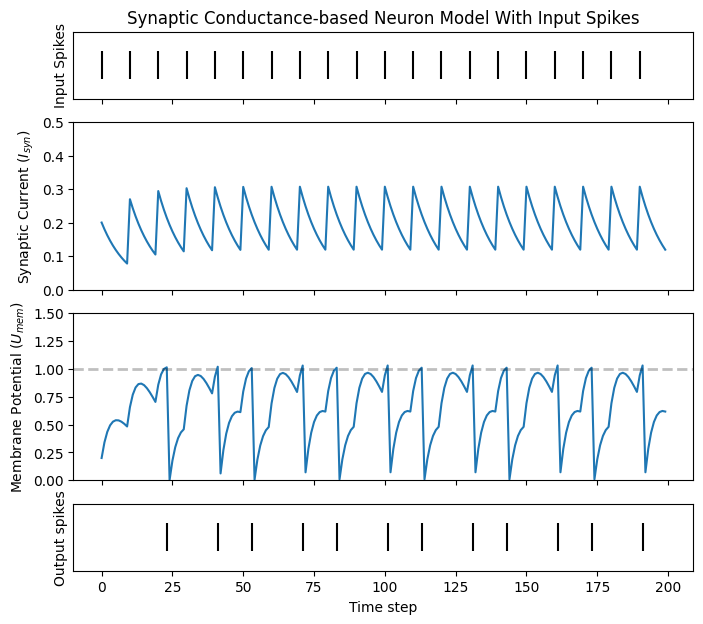

In [5]:
# Periodic spiking input, spk_in = 0.2 V
w = 0.2
spk_period = torch.cat((torch.ones(1)*w, torch.zeros(9)), 0)
spk_in = spk_period.repeat(20)

# Initialize hidden states and output
syn, mem = lif1.init_synaptic()
spk_out = torch.zeros(1)
syn_rec = []
mem_rec = []
spk_rec = []

# Simulate neurons
for step in range(num_steps):
  spk_out, syn, mem = lif1(spk_in[step], syn, mem)
  spk_rec.append(spk_out)
  syn_rec.append(syn)
  mem_rec.append(mem)

# convert lists to tensors
spk_rec = torch.stack(spk_rec)
syn_rec = torch.stack(syn_rec)
mem_rec = torch.stack(mem_rec)

plot_spk_cur_mem_spk(spk_in, syn_rec, mem_rec, spk_rec,
                     "Synaptic Conductance-based Neuron Model With Input Spikes")

该模型还具有 "复位机制"（`reset_mechanism`）和 "阈值"（`threshold`）这两个可选的输入参数，正如拉皮克神经元模型所描述的那样。总之，每个尖峰都会对突触电流 $I_{\rm syn}$ 产生移位指数衰减，并将所有电流相加。然后，该电流通过[教程 2](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)中推导的被动膜方程进行积分，从而产生输出尖峰。下面是这一过程的示意图。

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_7_stein.png?raw=true' width="600">
</center>

## 1.3 一阶神经元与二阶神经元

一个自然而然产生的问题是：什么时候我该使用一阶 LIF 神经元？什么时候我该使用二阶 LIF 神经元？

**使用二阶 LIF 神经元作为最优解时**

* 如果输入数据的时间单位发生在较长的区间
* 或者如果输入尖峰模式是稀疏的

通过两个具有两个衰减项（$\alpha$ 和 $\beta$）的递归方程，该神经元模型能够 "维持" 较长时间的输入尖峰。通过两个具有两个衰减项（$\alpha$ 和 $\beta$）的递归方程，这个神经元模型能够在更长的时间内 "维持" 输入尖峰。这有利于保持长期关系。

另一种用例也可能是：

* 当时间代码很重要时

如果您关心尖峰的精确时间，那么对于二阶神经元来说控制它似乎更容易。 在`Leaky`模型中，将与输入直接同步地触发尖峰。 对于二阶模型，膜电位被“平滑”（即突触电流模型对膜电位进行低通滤波），这意味着 $U[t]$ 经历有限的上升时间。 这在前面的模拟中很明显，输出尖峰相对于输入尖峰有延迟。

**使用一阶ELF 神经元作为最优解时**
* 任何不属于上述情况的情况，有时也属于上述情况。

在一阶神经元模型（如 `Leaky`）中少了一个方程，反向传播过程就会变得简单一些。尽管如此，当 $\alpha=0$ 时，`突触（Synaptic）` 模型在功能上等同于 `Leaky` 模型。在我自己对简单数据集的超参数扫描中，最佳结果似乎是将 $\alpha$ 尽可能推近 0。随着数据复杂度的增加，$\alpha$ 可能会越来越大。

# 2. Alpha 模型（魔改的尖峰反应模型）

尖峰响应模型（SRM）或 "阿尔法" 神经元的递归版本也可用 `snn.Alpha` 调用。迄今为止，所有神经元模型都是基于被动膜模型，使用常微分方程来描述其过程。

而 SRM 系列模型则用滤波器来解释。当输入尖峰到达时，该尖峰与滤波器卷积，从而得到膜电位响应。滤波器的形式可以是指数形式，如 Lapicque 神经元，也可以是更复杂的形式，如指数之和。SRM 模型很有吸引力，因为它们可以任意添加折射性、阈值适应性和其他任何特征，只需将它们嵌入滤波器即可。


<left>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/exp.gif?raw=true' width="400">
</left>

<right>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/alpha.gif?raw=true' width="400">
</right>



## 建立 Alpha 神经元模型
从形式上看，这一过程可以用以下方式表示

$$U_{\rm mem}(t) = \sum_i W(\epsilon * S_{\rm in})(t)$$

其中，输入的尖峰信号 $S_{\rm in}$ 与尖峰响应核 $\epsilon( \cdot )$ 进行卷积。尖峰响应按突触权重 $W$ 缩放。在上图中，左边的核是一个指数衰减函数，相当于拉皮克的一阶神经元模型。右图中，核是一个阿尔法函数：

$$\epsilon(t) = \frac{t}{\tau}e^{1-t/\tau}\Theta(t)$$

其中，$\tau$ 是阿尔法核的时间常数，$\Theta$ 是海维塞德阶跃函数。大多数基于核的方法都采用阿尔法函数，因为它提供了一个时间延迟，对于需要指定神经元精确尖峰时间的时序编码非常有用。

在 snnTorch 中，尖峰响应模型并不是直接作为滤波器来实现的。相反，它被重铸为递归形式，这样只需要使用上一时间步计算的值，用来计算下一组值。这大大减少了学习过程中的内存开销。

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_9_alpha.png?raw=true' width="600">
</center>

由于膜电位现在是由两个指数之和决定的，因此每个指数都有自己独立的衰减率。$\alpha$ 定义了正指数的衰减率，而 $\beta$ 定义了负指数的衰减率。

In [6]:
alpha = 0.8
beta = 0.7

# initialize neuron
lif2 = snn.Alpha(alpha=alpha, beta=beta, threshold=0.5)

使用该神经元与之前的神经元相同，但是两个指数函数的总和需要将突触电流`syn`拆分为 `syn_exc`和`syn_inh`分量：

**输入**
* `spk_in`：每个加权输入电压尖峰 $WX[t]$ 依次传入
* `syn_exc`: 上一个时间步的兴奋性突触后电流 $I_{\rm syn-exc}[t-1]$
* `syn_inh`: 上一个时间步的抑制性突触后电流 $I_{\rm syn-inh}[t-1]$
* `mem`: 膜电位 $U_{\rm mem}[t-1]$ 当前时间 $t$ 在上一个时间步

**输出**
* `spk_out`：当前时间步的输出尖峰 $S_{\rm out}[t]$ （如果有尖峰则为“1”；如果没有尖峰则为“0”）
* `syn_exc`：当前时间步 $t$ 的兴奋性突触后 $I_{\rm syn-exc}[t]$
* `syn_inh`：当前时间步 $t$ 的抑制性突触后电流 $I_{\rm syn-inh}[t]$
* `mem`：当前时间步的膜电位 $U_{\rm mem}[t]$

与所有其他神经元模型一样，这些模型必须是`torch.Tensor`类型。

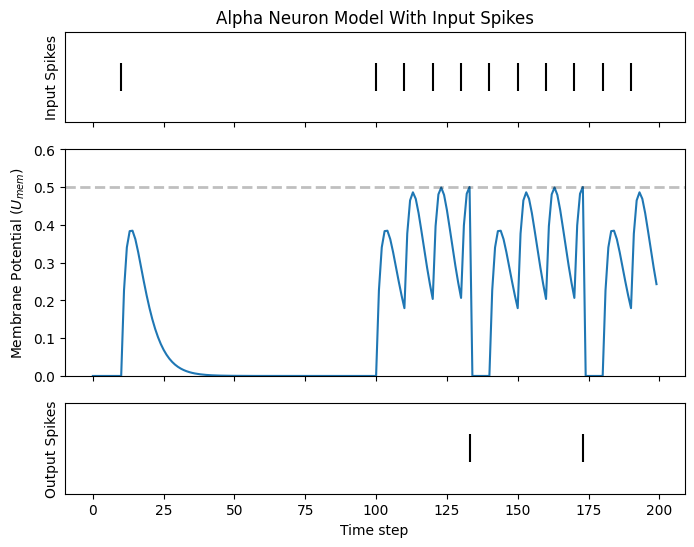

In [7]:
# input spike: initial spike, and then period spiking
w = 0.85
spk_in = (torch.cat((torch.zeros(10), torch.ones(1), torch.zeros(89),
                     (torch.cat((torch.ones(1), torch.zeros(9)),0).repeat(10))), 0) * w).unsqueeze(1)

# initialize parameters
syn_exc, syn_inh, mem = lif2.init_alpha()
mem_rec = []
spk_rec = []

# run simulation
for step in range(num_steps):
  spk_out, syn_exc, syn_inh, mem = lif2(spk_in[step], syn_exc, syn_inh, mem)
  mem_rec.append(mem.squeeze(0))
  spk_rec.append(spk_out.squeeze(0))

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_spk_mem_spk(spk_in, mem_rec, spk_rec, "Alpha Neuron Model With Input Spikes")

与之前的 Lapicque 和 突触（Synaptic） 的模型一样，Alpha 型号也有修改阈值和复位机制的选项。

## 2.2 实际情况是

正如前面提到的突触神经元，模型越复杂，训练过程中的反向传播过程就越复杂。在我自己的实验中，我还没有发现 Alpha 神经元模型 优于 突触(Synaptic)神经元模型 和 漏(Leaky)神经元模型 的情况。通过正负指数进行学习似乎只会增加梯度计算过程的难度，抵消在更复杂的神经元动态过程中的潜在优势。

然而，当 SRM 模型以时变核的形式表示（而不是像这里这样以递归模型的形式表示）时，它的表现似乎与较简单的神经元模型一样好。例如，请参阅以下论文：

> [*Sumit Bam Shrestha and Garrick Orchard, "SLAYER: Spike layer error reassignment in time", Proceedings of the 32nd International Conference on Neural Information Processing Systems, pp. 1419-1328, 2018.*](https://arxiv.org/abs/1810.08646)

加入 Alpha 神经元的目的是为将基于 SRM 的模型移植到 snnTorch 提供一个选项，尽管在这里对它们进行本机训练似乎不太有效。

# 结论

我们已经介绍了 snnTorch 中的所有 LIF 神经元模型。简单总结一下：

+ **Lapicque**：直接基于 RC 电路参数的物理精确模型
+ **漏 (Leaky)**：简化的一阶模型
+ **突触 (Synaptic)**：二阶模型，考虑突触电流演变
+ **Alpha**：膜电位跟踪Alpha函数的二阶模型

一般来说，"Leaky" 和 "Synaptic" 似乎对训练网络最有用。"Lapicque" 适合演示物理上精确的模型，而 "Alpha" 只用于捕捉 SRM 神经元的行为。

使用这些略微高级的神经元构建网络的步骤与 [教程 3](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)完全相同。

文档[可在此处](https://snntorch.readthedocs.io/en/latest/snntorch.html)供参考。

如果您喜欢这个项目，请考虑在 GitHub 上的 repo ⭐ 星级，因为这是最简单、最好的支持方式。

## Further Reading
* [Check out the snnTorch GitHub project here.](https://github.com/jeshraghian/snntorch)
* [snnTorch documentation](https://snntorch.readthedocs.io/en/latest/snntorch.html) of the Lapicque, Leaky, Synaptic, and Alpha models
* [*Neuronal Dynamics:
From single neurons to networks and models of cognition*](https://neuronaldynamics.epfl.ch/index.html) by
Wulfram Gerstner, Werner M. Kistler, Richard Naud and Liam Paninski.
* [Theoretical Neuroscience: Computational and Mathematical Modeling of Neural Systems](https://mitpress.mit.edu/books/theoretical-neuroscience) by Laurence F. Abbott and Peter Dayan